# Efficient Frontier

The following code calculates an Efficient Frontier for up to six assets. The user can choose which assets they would like to incorporate into their portfolio. Options include: S&P 500, Fixed Income, Gold, Private Credit, Real Estate, and Private Equity. The user can also select the time frame of the historical data used in the calculation.

In [145]:
import cvxpy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [146]:
dropped_assets_string = input("Input the assets you would like to drop.\nMake sure to spell the assets correctly and separate each with a comma and a space.\nIf you do not want to drop any assets, simply press enter: ")

In [147]:
dropped_assets = dropped_assets_string.split(", ")
dropped_assets

['']

In [148]:
time_frame = input("Choose your desired time frame in years (1-10): ")

In [149]:
#Read in Data
asset_data = pd.read_csv("EF_Data_Summary.csv")
asset_data

,Month,S&P 500,Fixed Income,Gold,Private Credit,Real Estate,Private Equity
0,1/30/15,1994.99,1955.02,1283.79,933.11,317.41,1744.85
1,2/27/15,2104.50,1936.64,1213.18,987.22,308.89,1903.96
2,3/31/15,2067.89,1945.63,1183.57,979.69,310.75,1854.04
3,4/30/15,2085.51,1938.65,1184.37,989.70,295.33,1890.64
4,5/29/15,2107.39,1933.98,1190.58,989.64,293.95,1925.25
...,...,...,...,...,...,...,...
115,8/30/24,5648.40,2228.33,2503.39,1466.30,380.90,5001.46
116,9/30/24,5762.48,2258.17,2634.58,1468.34,391.07,5150.10
117,10/31/24,5705.45,2202.17,2743.97,1457.96,376.82,5038.92
118,11/29/24,6032.38,2225.45,2643.15,1504.10,391.66,5458.17


In [150]:
#drop rows of assets user does not want
if dropped_assets_string:
    asset_data = asset_data.drop(dropped_assets, axis=1)
asset_data

,Month,S&P 500,Fixed Income,Gold,Private Credit,Real Estate,Private Equity
0,1/30/15,1994.99,1955.02,1283.79,933.11,317.41,1744.85
1,2/27/15,2104.50,1936.64,1213.18,987.22,308.89,1903.96
2,3/31/15,2067.89,1945.63,1183.57,979.69,310.75,1854.04
3,4/30/15,2085.51,1938.65,1184.37,989.70,295.33,1890.64
4,5/29/15,2107.39,1933.98,1190.58,989.64,293.95,1925.25
...,...,...,...,...,...,...,...
115,8/30/24,5648.40,2228.33,2503.39,1466.30,380.90,5001.46
116,9/30/24,5762.48,2258.17,2634.58,1468.34,391.07,5150.10
117,10/31/24,5705.45,2202.17,2743.97,1457.96,376.82,5038.92
118,11/29/24,6032.38,2225.45,2643.15,1504.10,391.66,5458.17


In [151]:
#Create variable used to filter to desired time frame
included_rows = int(time_frame)*12
included_rows

96

In [152]:
#Filter to the desired time frame
asset_data = asset_data.tail(included_rows)
asset_data

,Month,S&P 500,Fixed Income,Gold,Private Credit,Real Estate,Private Equity
24,1/31/17,2278.87,1980.25,1210.72,1082.03,305.20,2149.71
25,2/28/17,2363.64,1993.56,1248.44,1112.28,317.97,2243.78
26,3/31/17,2362.72,1992.51,1249.20,1114.96,311.62,2248.05
27,4/28/17,2384.20,2007.89,1268.28,1123.35,312.92,2282.20
28,5/31/17,2411.80,2023.34,1268.92,1082.06,312.17,2320.59
...,...,...,...,...,...,...,...
115,8/30/24,5648.40,2228.33,2503.39,1466.30,380.90,5001.46
116,9/30/24,5762.48,2258.17,2634.58,1468.34,391.07,5150.10
117,10/31/24,5705.45,2202.17,2743.97,1457.96,376.82,5038.92
118,11/29/24,6032.38,2225.45,2643.15,1504.10,391.66,5458.17


In [153]:
#Convert users' selected assets into a list for later use
selected_assets = asset_data.columns.tolist()
#take out Month
selected_assets = [col for col in selected_assets if col != 'Month']
# add "Weight" for later use
selected_assets = [col + ' Weight' for col in selected_assets]
selected_assets

['S&P 500 Weight',
 'Fixed Income Weight',
 'Gold Weight',
 'Private Credit Weight',
 'Real Estate Weight',
 'Private Equity Weight']

In [154]:
#Add "monthly return" to all columns besides Month
asset_data.columns = [col + " Monthly Return" if col != "Month" else col for col in asset_data.columns]

# Make every value a pct change except for the 'Month' column
asset_data.loc[:, asset_data.columns != "Month"] = asset_data.loc[:, asset_data.columns != "Month"].pct_change()
asset_data

,Month,S&P 500 Monthly Return,Fixed Income Monthly Return,Gold Monthly Return,Private Credit Monthly Return,Real Estate Monthly Return,Private Equity Monthly Return
24,1/31/17,NaN,NaN,NaN,NaN,NaN,NaN
25,2/28/17,0.037198,0.006721,0.031155,0.027957,0.041841,0.043759
26,3/31/17,-0.000389,-0.000527,0.000609,0.002409,-0.019970,0.001903
27,4/28/17,0.009091,0.007719,0.015274,0.007525,0.004172,0.015191
28,5/31/17,0.011576,0.007695,0.000505,-0.036756,-0.002397,0.016821
...,...,...,...,...,...,...,...
115,8/30/24,0.022835,0.014367,0.022794,-0.016757,0.053403,0.029783
116,9/30/24,0.020197,0.013391,0.052405,0.001391,0.026700,0.029719
117,10/31/24,-0.009897,-0.024799,0.041521,-0.007069,-0.036438,-0.021588
118,11/29/24,0.057301,0.010571,-0.036742,0.031647,0.039382,0.083202


In [155]:
#Remove unwanted data and drop first row
asset_data_returns = asset_data.loc[:, asset_data.columns.str.contains("Return")]
asset_data_returns = asset_data_returns.dropna()
asset_data_returns                                                         

,S&P 500 Monthly Return,Fixed Income Monthly Return,Gold Monthly Return,Private Credit Monthly Return,Real Estate Monthly Return,Private Equity Monthly Return
25,0.037198,0.006721,0.031155,0.027957,0.041841,0.043759
26,-0.000389,-0.000527,0.000609,0.002409,-0.019970,0.001903
27,0.009091,0.007719,0.015274,0.007525,0.004172,0.015191
28,0.011576,0.007695,0.000505,-0.036756,-0.002397,0.016821
29,0.004814,-0.001003,-0.021522,0.005952,0.013678,-0.004473
...,...,...,...,...,...,...
115,0.022835,0.014367,0.022794,-0.016757,0.053403,0.029783
116,0.020197,0.013391,0.052405,0.001391,0.026700,0.029719
117,-0.009897,-0.024799,0.041521,-0.007069,-0.036438,-0.021588
118,0.057301,0.010571,-0.036742,0.031647,0.039382,0.083202


In [156]:
#Calculate Avg Monthly Returns and Annualize it
expected_returns = asset_data_returns.mean()
expected_returns = (1 + expected_returns)**12 - 1
expected_returns

S&P 500 Monthly Return           0.141890
Fixed Income Monthly Return      0.014213
Gold Monthly Return              0.111485
Private Credit Monthly Return    0.063172
Real Estate Monthly Return       0.038171
Private Equity Monthly Return    0.158752
dtype: float64

In [157]:
#Calculate Covariance Matrix and Annualize it
cov_matrix = asset_data_returns.cov() * 12
cov_matrix

,S&P 500 Monthly Return,Fixed Income Monthly Return,Gold Monthly Return,Private Credit Monthly Return,Real Estate Monthly Return,Private Equity Monthly Return
S&P 500 Monthly Return,0.026209,0.003857,0.003714,0.024663,0.024749,0.042545
Fixed Income Monthly Return,0.003857,0.002938,0.002950,0.002663,0.005956,0.006010
Gold Monthly Return,0.003714,0.002950,0.016538,0.000298,0.005792,0.005717
Private Credit Monthly Return,0.024663,0.002663,0.000298,0.039226,0.027404,0.039638
Real Estate Monthly Return,0.024749,0.005956,0.005792,0.027404,0.034810,0.039157
Private Equity Monthly Return,0.042545,0.006010,0.005717,0.039638,0.039157,0.075631


In [158]:
#Primary Calculations
n = len(cov_matrix)
weights = cp.Variable(n)
weights

Variable((6,), var2878)

In [159]:
#Calculate Target Returns
target_returns = np.linspace(
expected_returns.min(),
expected_returns.max(),
10 # Number of points on the frontier
)
target_returns

array([0.0142126 , 0.03027253, 0.04633247, 0.0623924 , 0.07845234,
       0.09451227, 0.11057221, 0.12663214, 0.14269208, 0.15875201])

In [160]:
# Store results
efficient_portfolios = []
for target_return in target_returns:
    # Objective: Minimize portfolio variance
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    objective = cp.Minimize(portfolio_variance)
    # Constraints
    constraints = [
        weights >= 0, # No short-selling
        cp.sum(weights) == 1, # Fully invested
        expected_returns.values @ weights >= target_return # Target return
        ]
    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()
    if prob.status == 'optimal':
        annualized_return = expected_returns.values @ weights.value
        annualized_variance = portfolio_variance.value
        efficient_portfolios.append({
            'Weights': weights.value,
            'Return': annualized_return,
            'Variance': annualized_variance
            })

In [161]:
# Convert to DataFrame
efficient_frontier = pd.DataFrame(efficient_portfolios)
efficient_frontier['Standard Deviation'] = np.sqrt(efficient_frontier['Variance'])
# Remove duplicates (if any)
efficient_frontier = efficient_frontier.drop_duplicates(['Return', 'Variance'])
efficient_frontier

,Weights,Return,Variance,Standard Deviation
0,"[-5.942385841557337e-22, 0.9920801512628875, 0...",0.014621,0.002936,0.054183
1,"[0.03420604201738439, 0.8378598933330078, 0.11...",0.030273,0.003213,0.056685
2,"[0.11125864877913516, 0.7045705543193067, 0.18...",0.046332,0.003866,0.062178
3,"[0.17687240577295718, 0.559976693939088, 0.263...",0.062392,0.004865,0.069752
4,"[0.24248616276677923, 0.41538283355886935, 0.3...",0.078452,0.006215,0.078838
5,"[0.30809991976060125, 0.27078897317865064, 0.4...",0.094512,0.007916,0.088973
6,"[0.3737136767544233, 0.1261951127984318, 0.500...",0.110572,0.009968,0.099838
7,"[0.4981897058220712, 5.248913676748167e-23, 0....",0.126632,0.012527,0.111923
8,"[0.9524055495753043, 6.26260471763084e-21, 1.7...",0.142692,0.027802,0.166740
9,"[3.0577289883285886e-15, 1.3629673662158412e-2...",0.158752,0.075631,0.275011


In [162]:
# Split the 'Weights' into independent columns
efficient_frontier[selected_assets] = pd.DataFrame(efficient_frontier['Weights'].tolist(), index=efficient_frontier.index)

# Convert weights to percentages
efficient_frontier = efficient_frontier * 100

# Add '%' to the asset column names
efficient_frontier.columns = [f"{col} (%)" if 'Weight' in col else col for col in efficient_frontier.columns]

# Round the values to 2 decimal places
efficient_frontier = efficient_frontier.round(2)

# Change the index to 'Portfolio X' format
efficient_frontier.index = [f"Portfolio {i+1}" for i in range(len(efficient_frontier))]

# Rename columns
efficient_frontier = efficient_frontier.rename(columns={'Return': 'Expected Return (%)', 
                                                       'Variance': 'Variance (%)', 
                                                       'Standard Deviation': 'Standard Deviation (%)'})
#Drop Weights columns
efficient_frontier = efficient_frontier.drop("Weights (%)", axis=1)

#Drop Var Column
efficient_frontier = efficient_frontier.drop("Variance (%)", axis=1)
efficient_frontier

,Expected Return (%),Standard Deviation (%),S&P 500 Weight (%),Fixed Income Weight (%),Gold Weight (%),Private Credit Weight (%),Real Estate Weight (%),Private Equity Weight (%)
Portfolio 1,1.46,5.42,-0.00,99.21,0.04,0.75,-0.0,0.00
Portfolio 2,3.03,5.67,3.42,83.79,11.24,1.56,-0.0,-0.00
Portfolio 3,4.63,6.22,11.13,70.46,18.42,-0.00,-0.0,-0.00
Portfolio 4,6.24,6.98,17.69,56.00,26.32,0.00,0.0,0.00
Portfolio 5,7.85,7.88,24.25,41.54,34.21,0.00,0.0,0.00
Portfolio 6,9.45,8.90,30.81,27.08,42.11,0.00,0.0,0.00
Portfolio 7,11.06,9.98,37.37,12.62,50.01,0.00,0.0,0.00
Portfolio 8,12.66,11.19,49.82,0.00,50.18,0.00,0.0,-0.00
Portfolio 9,14.27,16.67,95.24,0.00,0.00,0.00,0.0,4.76
Portfolio 10,15.88,27.50,0.00,0.00,-0.00,0.00,0.0,100.00


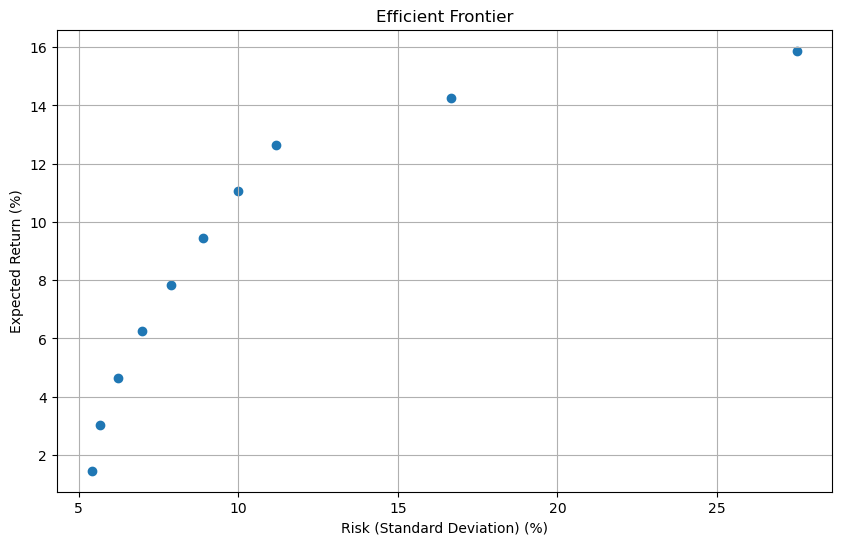

In [163]:
#Graph
plt.figure(figsize=(10, 6))
plt.scatter(
    efficient_frontier['Standard Deviation (%)'],
    efficient_frontier['Expected Return (%)'],
    marker='o'
)
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation) (%)')
plt.ylabel('Expected Return (%)')
plt.grid(True)
plt.show()